### Imports

In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [85]:
from plot import show_images, plot_history, plot_variance

In [3]:
num_workers = 2
batch_size = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {} device'.format(device))

Using cuda device


### Data loading

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5,), (0.5,))
    ])

transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, 
    transform=transform
)

test_data = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, 
    transform=transform
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



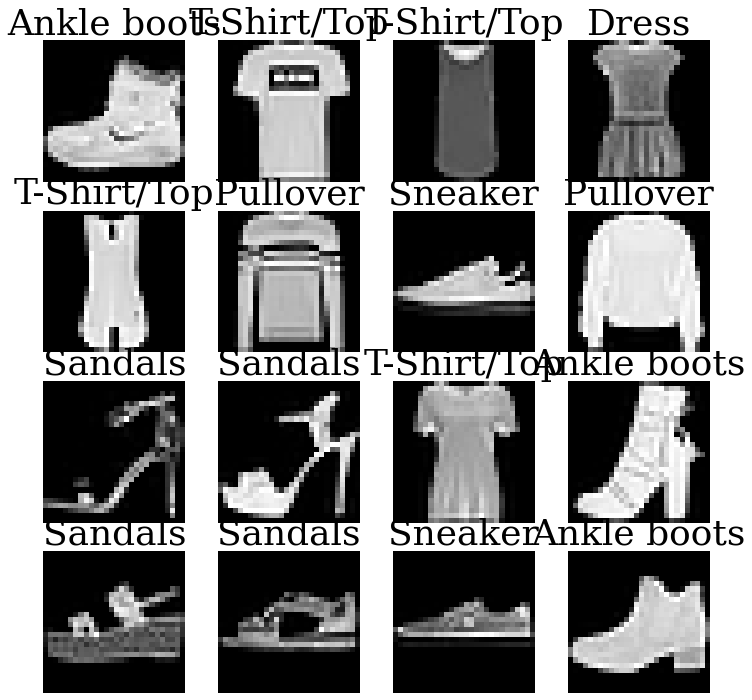

In [84]:
train_dataloader = torch.utils.data.DataLoader(
    train_data, shuffle=False, 
    batch_size=batch_size, num_workers=num_workers
)

test_dataloader = torch.utils.data.DataLoader(
    test_data, shuffle=False, 
    batch_size=batch_size, num_workers=num_workers
)

labels_map = {
    0: "T-Shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandals",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boots",
}

N_samples = 16
images, labels = next(iter(train_dataloader))
show_images(
    images[:N_samples], 
    [labels_map[i.item()] for i in labels[:N_samples]], 
    transform=transforms.ToPILImage()
)

### Teacher models training

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from training import train_loop, test_loop
from model import MLP

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

num_repeats = 10
epochs = 50

for i in range(num_repeats):
    clear_output()

    print(f"Model {i+1}\n-------------------------------"
                      "\n-------------------------------")

    torch.manual_seed(i)

    model = MLP(images[0].shape, n_classes=len(labels_map), blocks=[128, 64, 32]).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")

        train_loop(model, train_dataloader, loss_fn, optimizer)
        test_loop(model, test_dataloader, loss_fn)

    torch.save(model.state_dict(), f'/content/drive/MyDrive/models/teacher_{i}.pt')

### Plot quality stats for debug (every number of epochs on the plot training a new model)

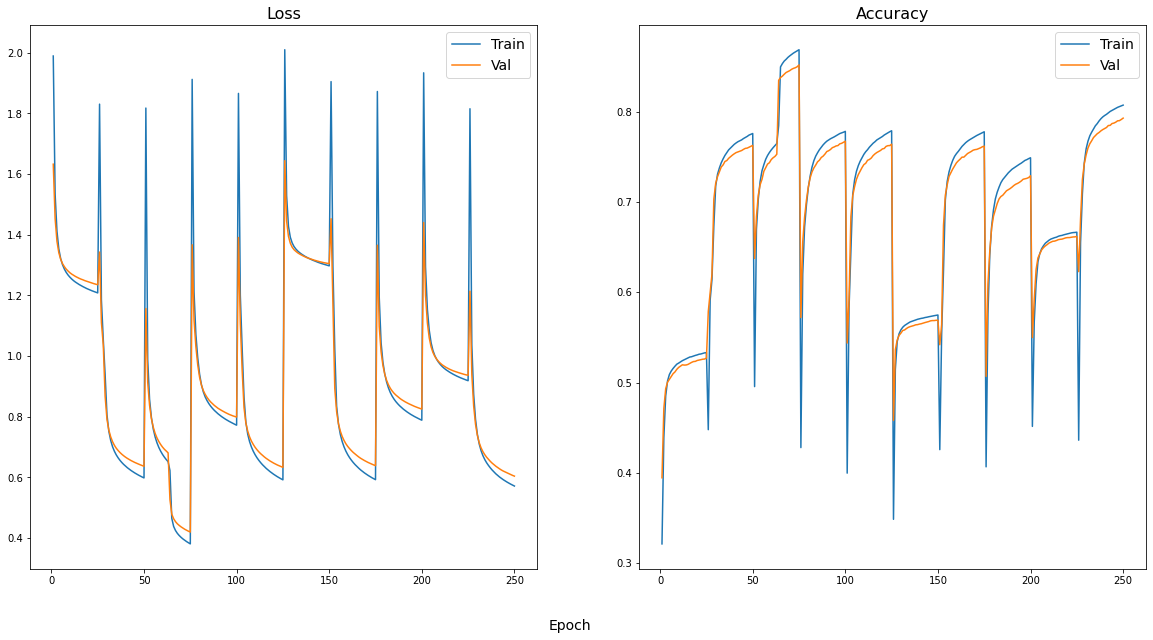

In [ ]:
plot_history()

In [ ]:
model

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (stack): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=32, out_features=10, bias=True)
      (1): ReLU()
    )
  )
)

### Code for training models with different kinds of initialization

In [51]:
from training import train
from antidistillation import change_weights

from IPython.display import clear_output

prefix = '/content/drive/MyDrive/models/'

scratch_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
zero_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
uniform_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

epochs = 15
num_repeats = 5
loss_fn = nn.CrossEntropyLoss()

for i in range(num_repeats):
    teacher_model = MLP(images[0].shape, n_classes=len(labels_map), blocks=[128, 64, 32]).to(device)
    teacher_model.load_state_dict(torch.load(prefix + f'teacher_{i}.pt'))

    for history, name in zip([scratch_history, zero_history, uniform_history], ['scratch_model', 'student_zero', 'student_uniform']):
        clear_output()
        torch.manual_seed(i + num_repeats)

        print(f'{name} {i+1}\n-------------------------------')

        model = MLP(images[0].shape, n_classes=len(labels_map), blocks=[128, 128, 32]).to(device)
        change_weights(model, teacher_model, name.split('_')[1])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        train()

        torch.save(model.state_dict(), prefix + f'{name}_{i}.pt')

student_uniform 10
-------------------------------
Epoch 1
-------------------------------


'[60000/60000] Loss: 0.568826'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 79.6%, Validation loss: 0.591456 

Epoch 2
-------------------------------


'[60000/60000] Loss: 0.558353'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 79.6%, Validation loss: 0.594153 

Epoch 3
-------------------------------


'[60000/60000] Loss: 0.542424'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 79.5%, Validation loss: 0.598107 

Epoch 4
-------------------------------


'[60000/60000] Loss: 0.523201'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 79.7%, Validation loss: 0.594305 

Epoch 5
-------------------------------


'[60000/60000] Loss: 0.516195'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 79.8%, Validation loss: 0.588904 

Epoch 6
-------------------------------


'[60000/60000] Loss: 0.515024'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 80.0%, Validation loss: 0.585726 

Epoch 7
-------------------------------


'[60000/60000] Loss: 0.503608'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 80.3%, Validation loss: 0.572785 

Epoch 8
-------------------------------


'[60000/60000] Loss: 0.457131'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 81.5%, Validation loss: 0.536143 

Epoch 9
-------------------------------


'[60000/60000] Loss: 0.453383'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 81.6%, Validation loss: 0.536377 

Epoch 10
-------------------------------


'[60000/60000] Loss: 0.450011'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 81.6%, Validation loss: 0.536583 

Epoch 11
-------------------------------


'[60000/60000] Loss: 0.447513'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 81.6%, Validation loss: 0.536873 

Epoch 12
-------------------------------


'[60000/60000] Loss: 0.445370'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 81.6%, Validation loss: 0.536775 

Epoch 13
-------------------------------


'[60000/60000] Loss: 0.443569'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 81.5%, Validation loss: 0.536880 

Epoch 14
-------------------------------


'[60000/60000] Loss: 0.441440'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 81.5%, Validation loss: 0.537019 

Epoch 15
-------------------------------


'[60000/60000] Loss: 0.443575'

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Batch #:   0%|          | 0/40 [00:00<?, ?it/s]

Validation accuracy: 81.8%, Validation loss: 0.531686 



### Plot results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


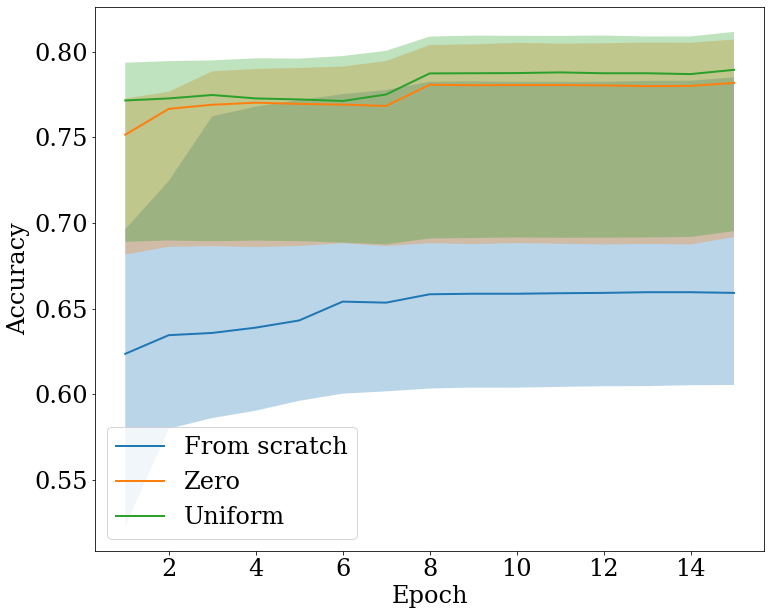

In [92]:
plot_variance([scratch_history, zero_history, uniform_history], ['From scratch', 'Zero', 'Uniform'], 'val_acc', 15, 'Epoch', 'Accuracy', 'accuracy')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


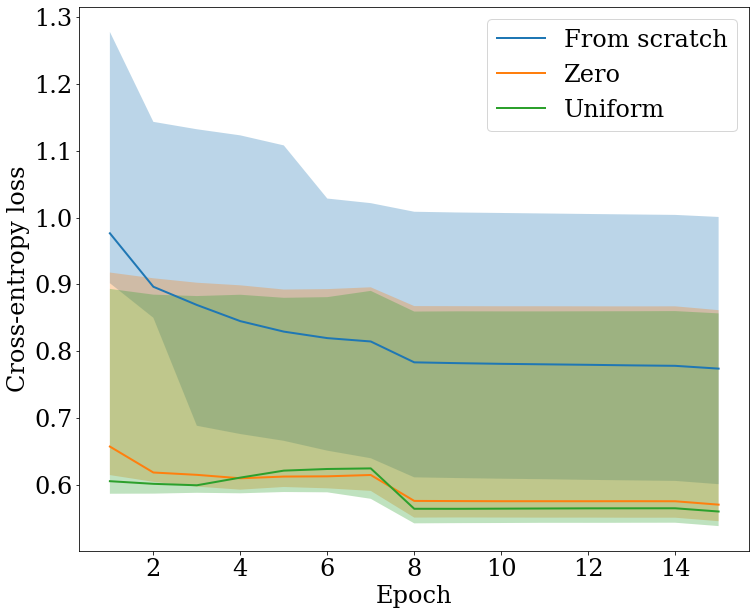

In [93]:
plot_variance([scratch_history, zero_history, uniform_history], ['From scratch', 'Zero', 'Uniform'], 'val_loss', 15, 'Epoch', 'Cross-entropy loss', 'loss')